In [1]:
#For noise generation
from opensimplex import OpenSimplex

#Plotting
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib notebook

#Numpy and scipy.stats for useful functionality and rain distributions
import numpy as np
import scipy.stats as sts

#Used to creating the next state when updating
import copy

# Terrain Generation

In [2]:
def noise(nx, ny):
    # Rescale from -1.0:+1.0 to 0.0:1.0
    return gen.noise2d(nx, ny) / 2.0 + 0.5

def ridgenoise(nx, ny):
    return 2*(0.5 - abs(0.5 - noise(nx, ny)))

def gen_normal(freqs, nx, ny, contrast):
    # Rescale from -1.0:+1.0 to 0.0:1.0
    value = [sum([(1/freq*noise(freq*x, freq*y))**contrast for freq in freqs]) for x, y in zip(nx, ny)]
    return value


def gen_ridge(freqs, nx, ny, contrast, slope = 0):
    value = []
    for x, y in zip(nx,ny):
        row = [1/freqs[0]*ridgenoise(freqs[0]*x, freqs[0]*y)]
        for i in range(1, len(freqs)):
            row.append(1/freqs[i]*ridgenoise(freqs[i]*x, freqs[i]*y)*sum(row))
        value.append(sum(row)+slope*y)
    return [val**contrast for val in value]

def gen_grid(xN, yN, stepsize, freqs, contrast, slope):
    x = np.arange(0, xN, stepsize)
    y = np.arange(0, yN, stepsize)
    X, Y = np.meshgrid(x, y)
    zs = np.array(gen_ridge(freqs, np.ravel(X), np.ravel(Y), contrast, slope))
    Z = zs.reshape(X.shape)
    return X, Y, Z

# CA implementation

In [114]:
class Mountains:
    #The rainfall_distribution object must only be able to return non-negative values.
    def __init__(self, X, Y, height_map, rainfall_dist):
        #Matrices of X and Y values.
        #Needed for surface plots.
        self.X = X
        self.Y = Y
        
        #Distribution for rainfall, usually exponential
        self.rain_dist = rainfall_dist
        #Heightmap and
        self.heights = height_map
        self.water = np.zeros(np.shape(self.heights))
        self.total = self.heights + self.water
        self.flow = np.zeros(np.shape(self.heights))
        self.last_transfer = np.zeros((3,3))
        self.maxflow_hist = []
        self.tot_water_hist = []
        
    def update(self, flow_update = True):
        #Add rain
        self.rainfall()
        nextwater = copy.deepcopy(self.water)
        
        for y in range(len(self.heights)):
            for x in range(len(self.heights[y])):
                cell_change = np.zeros((3,3))
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        #If at the border
                        if x+dx < 0 or x+dx == len(self.heights[y]) or y+dy < 0 or y+dy == len(self.heights):
                            #Drain the cell. /6 for full drainage each step
                            cell_change[dy+1][dx+1] = self.water[y][x]/6
                        else:
                            #Calculate difference
                            delta = self.total[y][x]-self.total[y+dy][x+dx]
                            if delta > 0:
                                #Move half the difference to have equal waterlevel
                                #Set to delta/6 so three cells are needed to completely drain
                                cell_change[dy+1][dx+1] = delta/6
                
                #If we're trying to pull out more water than available
                if np.sum(cell_change)>self.water[y][x]:
                    #Normalize outflow to be equal to the amount of water available
                    cell_change = self.water[y][x]*cell_change/np.sum(cell_change)
                nextwater[y][x] += -np.sum(cell_change)
                
                if flow_update == True:
                    flow = 0
                    for r in range(len(cell_change)):
                        for c in range(len(cell_change[r])):
                            if self.last_transfer[r][c] != 0:
                                flow += cell_change[r][c]
                    self.flow[y][x] = flow
                    self.last_transfer = cell_change
                
                #Finally, update the waterlevels.
                #This has to be done now because we first had to normalize the amount
                #of water getting drained to each neighbor.
                for dy in [-1, 0, 1]:
                    for dx in [-1, 0, 1]:
                        #If at the border, don't update
                        if x+dx < 0 or x+dx == len(self.heights[y]) or y+dy < 0 or y+dy == len(self.heights):
                            pass
                        #We already updated the middle cell
                        elif dx == 0 and dy == 0:
                            pass
                        else:
                            nextwater[y+dy][x+dx] += cell_change[dy+1][dx+1]
        
        
        #Move attributes to next time-step
        self.maxflow_hist.append(max(self.flow.flatten()))
        self.water = nextwater
        self.tot_water_hist.append(sum(sum(self.water)))
        self.total = self.heights + self.water
        
    def rainfall(self):
        #Generate the amount of rain dropping on each cell and add them to the current waterlevel
        self.water += self.rain_dist.rvs(size=self.heights.shape)

# Terrain generation test

<ipython-input-136-009decd7ce33>:29: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


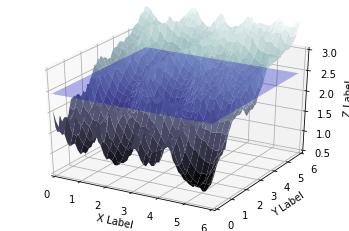

In [136]:
gen = OpenSimplex(seed = 1)

freqs = [0.8, 1.6, 3.2, 6.4, 12.8]#, 3.2]
contrast = 0.6
slope = 1
xN = 6
yN = 6
stepsize = 0.1


X, Y, Z = gen_grid(xN, yN, stepsize, freqs, contrast, slope)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, cmap = 'bone', alpha = 1)
water = np.full(np.shape(Z),np.mean(Z))
ax.plot_surface(X, Y, water, color = 'blue', alpha = 0.3)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# Set each axis limits
ax.set_xlim(0,6)
ax.set_ylim(0,6) 
ax.set_zlim(0.5,3)

plt.show()

# Topdown view test

<ipython-input-137-be03b2705430>:6: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


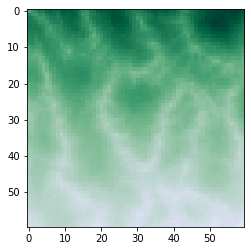

In [137]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, cmap='Greens_r')
watercolor = colors.ListedColormap(['blue'])
ax.imshow(np.full(np.shape(Z),0.3), cmap = watercolor, alpha = 0.1)
plt.show()

# Custom colormap for water overlay with varying alpha depending on water level

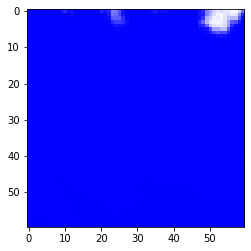

In [9]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

cm = LinearSegmentedColormap.from_list("custom", [(0,0,1,1),(0,0,1,1)], N=255)
# Choose colormap
cmap = cm# pl.cm.Blues

# Get the colormap colors
my_Blues = cmap(np.arange(cmap.N))

# Set alpha
my_Blues[:,-1] = 1/(1+28*np.exp(-50*np.linspace(0, 1, cmap.N)))

# Create new colormap
my_Blues = ListedColormap(my_Blues)


fig = plt.figure()
ax = fig.add_subplot(111)
#ax.imshow(mount.heights, cmap = "Greens")
ax.imshow(mount.heights, cmap=my_Blues)
#ax.imshow(mount.flow, cmap='viridis', alpha = 0.9)
plt.show()

# Custom colormap for flow overlay with varying alpha depending on flow

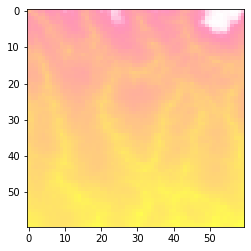

In [10]:
from matplotlib import cm
viridisBig = cm.get_cmap('spring', 512)
newcmp = ListedColormap(viridisBig(np.linspace(0.3, 1, 256)))

my_viridis = newcmp(np.arange(newcmp.N))

# Set alpha
my_viridis[:,-1] = 0.7/(1+100*np.exp(-60*np.linspace(0, 1, newcmp.N)))

# Create new colormap
my_viridis = ListedColormap(my_viridis)


fig = plt.figure()
ax = fig.add_subplot(111)
#ax.imshow(mount.heights, cmap = "Blues")
ax.imshow(mount.heights, cmap=my_viridis)
#ax.imshow(mount.flow, cmap='viridis', alpha = 0.9)
plt.show()

# Old gif animation. See below for MP4

In [11]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

freqs = [0.8, 1.6, 3.2]
contrast = 0.2
slope = 0.5
xN = 6
yN = 6
stepsize = 0.1

rain_distribution = sts.expon(0,0.0001)
X, Y, Z = gen_grid(xN, yN, stepsize, freqs, contrast, slope)

mount = Mountains(X, Y, Z, rain_distribution)

bottom = np.zeros(np.shape(Z))
#global testingwater
width = depth = stepsize

barx = np.reshape(mount.X, np.prod(mount.X.shape), order='C')
bary = mount.Y.flatten()
barz = np.reshape(mount.heights, np.prod(mount.X.shape), order='C')
barbot = np.reshape(bottom, np.prod(mount.X.shape), order='C')
barw = np.reshape(mount.water, np.prod(mount.X.shape), order='C')


def init_animation():
    ax1.view_init(elev=40, azim=0)
    ax1.bar3d(barx, bary, barbot, width, depth, barz, shade=True, color = "grey")
    ax1.bar3d(barx, bary, barz, width, depth, barw, shade=True, alpha = 0.3, color = "blue")

def animate(i):
    #global testingwater
    label = 'timestep {0}'.format(int(i))
    mount.update()
    barw = np.reshape(mount.water, np.prod(X.shape), order='C')
    
    ax1.cla()
    ax1.view_init(elev=40, azim=i/2)
    bar1 = ax1.bar3d(barx, bary, barbot, width, depth, barz, shade=True, color = "grey")
    bar2 = ax1.bar3d(barx, bary, barz, width, depth, barw, shade=True, alpha = 0.3, color = "blue")
    ax1.set_xlabel(label)
    return bar2

'''
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init_animation, frames=180)
ani.save('flow_testing.gif', writer="pillow", fps=10)
'''

'\nfig = plt.figure()\nax1 = fig.add_subplot(111, projection=\'3d\')\nani = matplotlib.animation.FuncAnimation(fig, animate, init_func=init_animation, frames=180)\nani.save(\'flow_testing.gif\', writer="pillow", fps=10)\n'

# Functions to generate the plots for each frame of the animation. Currently jumping 4 steps per frame

In [40]:
def init_imshow():
    im_mount.set_data(mount.heights)
    im_water.set_data(mount.water)
    im_flow1.set_data(mount.flow)
    im_flow2.set_data(mount.flow)
    return im_mount, im_water, im_flow1, im_flow2

def animate_imshow(i):
    if i%100 == 0:
        print(i)
    label = 'Timestep {0}'.format(int(offset+(4*i)))
    mount.update()
    mount.update()
    mount.update()
    mount.update()

    #ax1.cla()
    #ax2.cla()
    im_mount.set_data(mount.heights)
    im_water.set_data(mount.water)
    im_flow1.set_data(mount.flow)
    im_flow2.set_data(mount.flow)
    ax1.set_title("Topology with water and flow overlay")
    ax2.set_title("Flow")
    ax1.set_xlabel(label)
    ax2.set_xlabel(label)
    return im_mount, im_water, im_flow1, im_flow2

# Animation generation

0
0


<ipython-input-115-dea0f5e5482e>:54: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


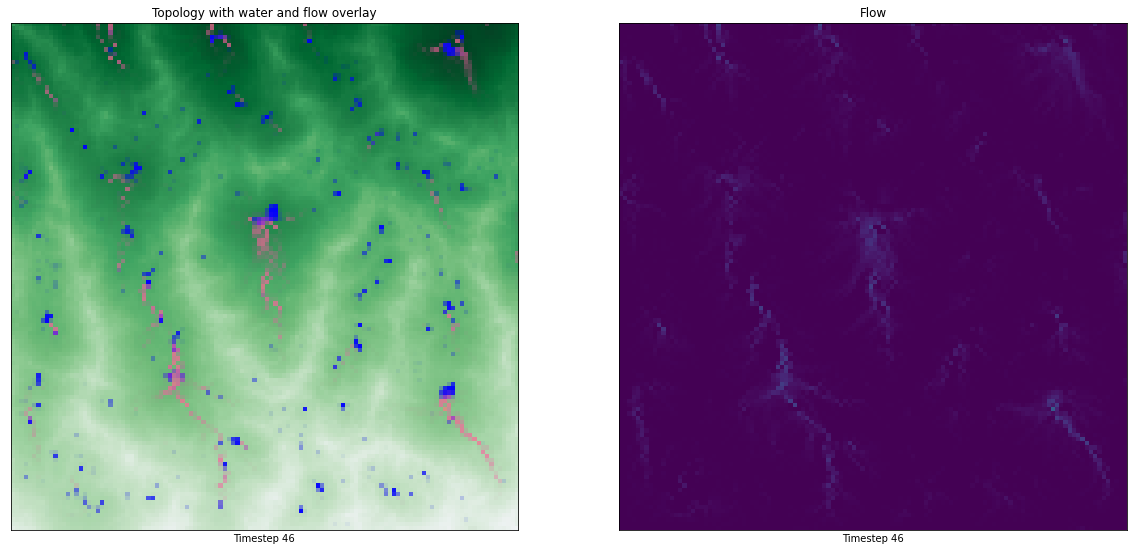

In [115]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.animation
import numpy as np

freqs = [0.8, 1.6, 3.2, 6.4, 12.8, 25.6]
#Contrast [0.2, 0.6, 1]
contrast = 1
slope = 1
xN = 6
yN = 6

#Default 0.05
stepsize = 0.05

#Default 500. Let the water converge a bit
offset = 10

#0.00005
rain_distribution = sts.expon(0,0.000025) #halved RAINFALL
X, Y, Z = gen_grid(xN, yN, stepsize, freqs, contrast, slope)

mount = Mountains(X, Y, Z, rain_distribution)
for i in range(offset+1):
    if i%100 == 0:
        print(i)
    mount.update(flow_update = False)
    
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121)
ax1.axes.xaxis.set_ticks([])
ax1.axes.yaxis.set_ticks([])

ax2 = fig.add_subplot(122)
ax2.axes.xaxis.set_ticks([])
ax2.axes.yaxis.set_ticks([])

im_mount = ax1.imshow(mount.heights, cmap='Greens_r')
im_water = ax1.imshow(mount.water, cmap=my_Blues, vmin=0, vmax=0.5)
im_flow1 = ax1.imshow(mount.flow, cmap=my_viridis, vmin=0, vmax=0.03)
im_flow2 = ax2.imshow(mount.flow, cmap='viridis', vmin=0, vmax=0.03)

'''
ani = matplotlib.animation.FuncAnimation(fig, animate_imshow, init_func=init_imshow, frames=2)
ani.save('mp4test.mp4', writer="pillow", fps=30)
'''

anim = animation.FuncAnimation(fig, animate_imshow, init_func=init_imshow,
                               frames=10, blit=True)

#anim.save('Contrast1Slope1Rainfall_0_000025.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
anim.save('totwatertest.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
plt.show()

# Create permanent saves of the mount ranges since they take potentially hours to generate

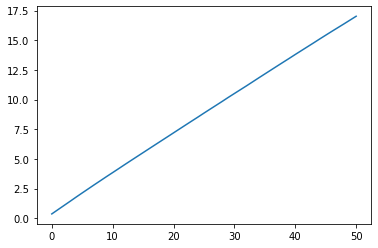

In [116]:
#mount02contrast = mount
#mount06contrast = mount
#mount1contrast = mount

In [39]:
import pickle

with open('mount06contrastv2_data.pkl', 'wb') as output:
    pickle.dump(mount06contrast, output, pickle.HIGHEST_PROTOCOL)



#with open('mount02contrast_data.pkl', 'rb') as input:
#    mount02contrast = pickle.load(input)


"\nwith open('mount02contrast_data.pkl', 'rb') as input:\n    mount02contrast = pickle.load(input)\n"

# Run multiple simulations without creating animations in order to make plots with confidence intervals.

In [124]:
from IPython.display import clear_output

freqs = [0.8, 1.6, 3.2, 6.4, 12.8, 25.6]
#Contrast [0.2, 0.6, 1]
contrast = 0.6
slope = 1
xN = 6
yN = 6

#Default 0.05
stepsize = 0.1

#Default 500. Let the water converge a bit
offset = 5000

#0.00005
rain_distribution = sts.expon(0,0.00005) #halved RAINFALL

mountains = []

for i in range(4):
    print("Mountain ",i)
    X, Y, Z = gen_grid(xN, yN, stepsize, freqs, contrast, slope)
    mount = Mountains(X, Y, Z, rain_distribution)

    for j in range(offset+1):
        mount.update()
    
    mountains.append(mount)
    clear_output()


with open('totwater_data.pkl', 'wb') as output:
    pickle.dump(mountains, output, pickle.HIGHEST_PROTOCOL)


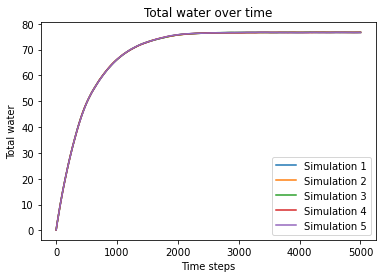

In [125]:
count = 1
for mtn in mountains:
    xs = np.linspace(0,len(mtn.tot_water_hist),len(mtn.tot_water_hist))
    plt.plot(xs, mtn.tot_water_hist, label = "Simulation " + str(count))
    count+=1
plt.title("Total water over time")
plt.xlabel("Time steps")
plt.ylabel("Total water")
plt.legend()

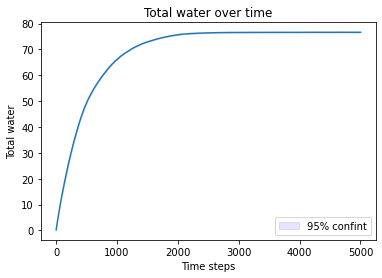

In [127]:
zipped = []
for i in range(len(mountains[0].tot_water_hist)):
    zipped.append([mountains[j].tot_water_hist[i] for j in range(len(mountains))])
    

avg_lists = [np.mean(step) for step in zipped]


xs = np.linspace(0,len(mountains[0].tot_water_hist),len(mountains[0].tot_water_hist))
cis = np.asarray([1.96 * np.std(step)/np.mean(step) for step in zipped])
    
cplus = np.asarray(avg_lists)+cis
cminus = np.asarray(avg_lists)-cis

fig, ax = plt.subplots()
ax.plot(xs,avg_lists)
ax.fill_between(xs[100:], cminus[100:], cplus[100:], color='b', alpha=.1, label = "95% confint")
ax.set_title("Total water over time")
ax.set_xlabel("Time steps")
ax.set_ylabel("Total water")
plt.legend()

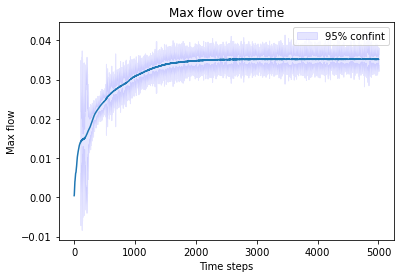

In [118]:
zipped = []
for i in range(len(longmountains[0].maxflow_hist)):
    zipped.append([longmountains[j].maxflow_hist[i] for j in range(len(longmountains))])
    

avg_lists = [np.mean(step) for step in zipped]


xs = np.linspace(0,len(longmountains[0].maxflow_hist),len(longmountains[0].maxflow_hist))
cis = np.asarray([1.96 * np.std(step)/np.mean(step) for step in zipped])
    
cplus = np.asarray(avg_lists)+cis
cminus = np.asarray(avg_lists)-cis

fig, ax = plt.subplots()
ax.plot(xs,avg_lists)
ax.fill_between(xs[100:], cminus[100:], cplus[100:], color='b', alpha=.1, label = "95% confint")
ax.set_title("Max flow over time")
ax.set_xlabel("Time steps")
ax.set_ylabel("Max flow")
plt.legend()